In [1]:
import tensorflow as tf
import numpy as np

In [2]:
class SequentialEncoder(tf.keras.Sequential):
    def call(self, *inputs):
        x, paded_mask = inputs
        for index,layer in enumerate(self.layers):
            x = layer(x, paded_mask)
        return x


class Encoder(tf.keras.Model):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_rate_1, drop_rate_2, drop_rate_ffn, num_layers):
        super().__init__()
        self.layers_ = SequentialEncoder()
        for i in range(num_layers):
            self.layers_.add(EncoderLayer(d_model, ffn_hidden, num_heads, drop_rate_1, drop_rate_2, drop_rate_ffn))

    def call(self, x, paded_mask):
        x = self.layers_(x, paded_mask)
        return x

In [3]:
class EncoderLayer(tf.keras.Model):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_rate_1, drop_rate_2, drop_rate_ffn):
        super().__init__()
        self.attention = MultiHeadAttention_Encoder(d_model=d_model, num_heads=num_heads) #Custom Implemented
        self.norm1 = LayerNormalization_Encoder(parameters_shape=[d_model]) #Custom Implemented
        self.dropout1 = tf.keras.layers.Dropout(drop_rate_1) 
        self.ffn = PositionwiseFeedForward_Encoder(d_model=d_model, hidden=ffn_hidden, drop_rate=drop_rate_ffn) #Custom Implemented
        self.norm2 = LayerNormalization_Encoder(parameters_shape=[d_model])
        self.dropout2 = tf.keras.layers.Dropout(drop_rate_2)

    def call(self, x, paded_mask):
        
        residual_x = x # for skipconnetctions
        x = self.attention(x,paded_mask) # Attention layer
        x = self.dropout1(x) # Dropout Layer
        
        x = self.norm1(x + residual_x) ## Add and Normalization
        residual_x = x  # for skipconnetctions
        x = self.ffn(x) # Feed Froward
        
        x = self.dropout2(x) ## Dropout
        x = self.norm2(x + residual_x) ## Add and Normalization
        return x

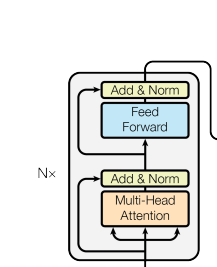

In [4]:
class MultiHeadAttention_Encoder(tf.keras.Model):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = tf.keras.layers.Dense(units=d_model * 3, use_bias=False)
        self.linear_layer = tf.keras.layers.Dense(d_model)

    def call(self, x, paded_mask):
        batch_size, max_sequence_length, d_model = x.shape
        qkv = self.qkv_layer(x)  # batch_size, #max_sequence_length, #d_model*3
        qkv = tf.reshape(qkv, shape=(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)) #batch_size x max_sequence_length x num_heads x 3 * self.head_dim
        # We obtain Q, K, and V with a single layer, which is equivalent to breaking it down and constructing Q_i, K_i, and V_i separately for each value of i where num_heads >= i >= 1
        qkv = tf.reshape(qkv, shape=(qkv.shape[0], qkv.shape[2], qkv.shape[1],qkv.shape[3]))
        # Reshape for performing the (Q @ K.t) operation for each head
        q, k, v = tf.split(qkv, num_or_size_splits=3, axis=3)
        values, attention = scaled_dot_product_Encoder(q, k, v, paded_mask)
        values = tf.reshape(values, shape=(batch_size, max_sequence_length, self.num_heads * self.head_dim))
        #The above reshape operation is equivalent to concatenation
        out = self.linear_layer(values)
        return out

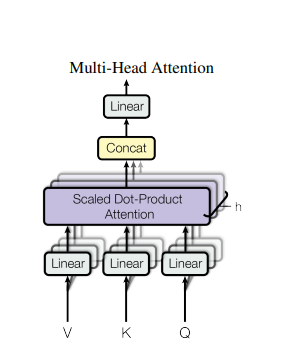

In [5]:
def scaled_dot_product_Encoder(q, k, v, indexes):
    d_k = q.shape[-1]
    scaled = tf.matmul(q, tf.transpose(k, perm=[0, 1, 3, 2])) / d_k ** 0.5
    if indexes is not None:
        attention = masked_padding_Encoder(scaled, indexes)
        values = tf.matmul(attention, v)
        return values, attention

    attention = tf.keras.activations.softmax(scaled, axis=-1)
    values = tf.matmul(attention, v)
    return values, attention



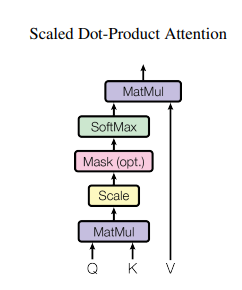

In [6]:
def masked_padding_Encoder(tensor, indexes):
    a, b, c, d = tensor.shape
    indexes  # shape batch_size x max_seq_lenght
    tensor  # shape batch_size x num_heds x max_seq_lenght  xmax_seq_lenght
    indexes = indexes.numpy()
    indexes_not = np.logical_not(indexes)
    tensor = tensor.numpy()
    returned_array = np.zeros(shape=(a, b, c, d))
    for i, j in enumerate(indexes):
        k = tensor[i]
        k[:, indexes_not[i], :] = 0
        k[:, :, indexes_not[i]] = 0
        values_for_softmax = k[:, j, :][:, :, j]
        values_for_softmax = tf.keras.activations.softmax(tf.constant(values_for_softmax))
        values_for_softmax = values_for_softmax.numpy()
        k[np.where(k != 0)] = values_for_softmax.flatten()
        returned_array[i] += k
    return tf.constant(returned_array, dtype=tf.float32)

When we perform text preprocessing, sentences vary in length, and we pad these sentences to the length of the maximum sequence. These padded <words> do not hold any meaning during training. When obtaining the attention weight matrix, we need to replace all the rows and columns with zeros where the attention weights are constructed for padded sequences

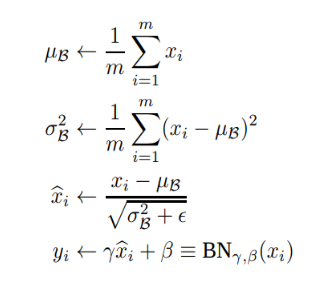

In [8]:
class PositionwiseFeedForward_Encoder(tf.keras.Model):

    def __init__(self, d_model, hidden, drop_rate=0.1):
        super(PositionwiseFeedForward_Encoder, self).__init__()
        self.linear1 = tf.keras.layers.Dense(hidden)
        self.linear2 = tf.keras.layers.Dense(d_model, activation="linear")
        self.relu = tf.keras.activations.relu
        self.dropout = tf.keras.layers.Dropout(drop_rate)

    def call(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# FFN(x) = max(0, xW1 + b1)W2 + b2

Testing

In [9]:
d_model = 512  ## Hyper parametw from original Attention Is All You Need Paper
num_heads = 8  ## Hyper parametw from original Attention Is All You Need Paper
drop_rate_1 = 0.1
drop_rate_2 = 0.1
drop_rate_3 = 0.1
drop_rate_ffn = 0.1
batch_size = 32
max_sequence_length = 67
ffn_hidden = 2048 ## Hyper parametw from original Attention Is All You Need Paper
num_layers = 6  ## Hyper parametw from original Attention Is All You Need Paper

In [17]:
Batch = tf.random.normal(shape=(batch_size,max_sequence_length,d_model)) ##Asume data is passed into Embdding Layer and Positional Emb. Layer

In [20]:
output = Ecoder_Block(Batch,paded_mask=None)

In [21]:
Ecoder_Block.summary()

Model: "encoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_encoder_2 (Sequ  multiple                  18905088  
 entialEncoder)                                                  
                                                                 
Total params: 18905088 (72.12 MB)
Trainable params: 18905088 (72.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
one_Encoder_block = EncoderLayer(d_model,ffn_hidden,num_heads,drop_rate_1,drop_rate_2,drop_rate_ffn)

In [25]:
Out= one_Encoder_block(Batch,paded_mask=None)

In [26]:
one_Encoder_block.summary()

Model: "encoder_layer_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_attention__enco  multiple                  1049088   
 der_18 (MultiHeadAttention                                      
 _Encoder)                                                       
                                                                 
 layer_normalization__encod  multiple                  1024      
 er_36 (LayerNormalization_                                      
 Encoder)                                                        
                                                                 
 dropout_54 (Dropout)        multiple                  0         
                                                                 
 positionwise_feed_forward_  multiple                  2099712   
 _encoder_18 (PositionwiseF                                      
 eedForward_Encoder)                              

In [66]:
b=tf.keras.layers.Dense(6)

In [68]:
a = tf.random.normal(shape=(10,10))

In [69]:
b(a)

<tf.Tensor: shape=(10, 6), dtype=float32, numpy=
array([[-2.1272662 , -1.3339014 , -0.05315635,  2.4759026 , -0.33852375,
         0.5749148 ],
       [ 0.92039037, -0.10843331, -1.5031561 , -0.13631973,  0.54044557,
        -1.295224  ],
       [ 0.9883681 ,  0.25876477,  0.7874336 , -1.5946674 ,  1.4478047 ,
        -0.7203672 ],
       [ 0.74260366,  0.29600513, -2.483359  ,  0.6143034 ,  1.5263163 ,
         0.05920422],
       [ 1.3265005 ,  1.384631  ,  0.29690117, -0.9228376 , -1.6733059 ,
         0.7705459 ],
       [ 0.44675493,  1.7472048 ,  0.01399562, -1.9068255 ,  0.7412002 ,
         1.232112  ],
       [-0.04119204,  0.38088536,  2.5923302 ,  0.316096  , -1.7242923 ,
         0.20284402],
       [ 0.42415756, -1.2201196 , -2.559263  ,  0.99616694, -0.7900278 ,
         0.35926294],
       [-0.05769896, -0.2868786 , -1.4706093 ,  0.85900855, -1.1281432 ,
         0.8752173 ],
       [ 1.5963211 ,  0.47188923,  1.1422232 ,  0.38649213,  1.1216701 ,
        -1.8385878 ]], 

In [70]:
b.weights

[<tf.Variable 'dense_79/kernel:0' shape=(10, 6) dtype=float32, numpy=
 array([[ 0.3332939 , -0.19153473, -0.45161852, -0.41467634,  0.18922162,
         -0.36505818],
        [-0.03065377,  0.52936417,  0.49003273, -0.32775393, -0.3593135 ,
          0.4504724 ],
        [-0.20968673,  0.06889832,  0.14450139, -0.25321516,  0.5044734 ,
         -0.25700054],
        [ 0.5503339 ,  0.5127035 , -0.29465085, -0.27132252,  0.5947688 ,
         -0.23766083],
        [ 0.01024574, -0.14335206,  0.5657472 , -0.15759417,  0.4527108 ,
         -0.2600308 ],
        [-0.59131956, -0.30505502, -0.16807762,  0.49076885,  0.06393629,
          0.00969899],
        [-0.47114965, -0.5932218 ,  0.03857929,  0.18431014, -0.28269482,
          0.5122562 ],
        [ 0.483218  , -0.01377195, -0.03674275,  0.33185875,  0.22889811,
         -0.02541089],
        [-0.40676296, -0.11195064, -0.5862589 , -0.46435258,  0.61002356,
          0.37938106],
        [-0.2719572 , -0.49787354, -0.04809523,  0.516506